# 前処理可視化ノート
前処理モジュール `src/utils/preprocessing.py` で実装した各種処理の効果を確認するためのデモです。

## 検証内容
- A. 基本統計（mean, std, max, min, range, RMS等）
- B. ピーク & 周期（ピーク数、ゼロ交差数等）
- C. FFT / 周波数（周波数バンドエネルギー）
- D. ワールド線形加速度（姿勢補正と重力除去）
- E. 欠損フラグ（センサー欠損の検出）
- F. Demographics（被験者属性情報）
- G. TDA Stats（トポロジカルデータ解析）※optional
- H. AE 再構成誤差（異常検知的アプローチ）※optional
- I. その他の前処理機能

ハイパーパラメータは `config.yaml` から読み込みます。

In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.append('/mnt/c/Users/ShunK/works/CMI_comp/')
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import preprocessing
from src.utils.config_utils import get_preprocessing_params
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 設定パラメータ
try:
    params = get_preprocessing_params()
except:
    # config.yamlが無い場合のデフォルト設定
    params = {
        'sampling_rate': 50.0,
        'window_size': 256,
        'stride': 128,
        'fft_bands': [(0.5, 2), (2, 5), (5, 10), (10, 20)]
    }

window_size = params.get('window_size', 256)
stride = params.get('stride', 128)
fs = params.get('sampling_rate', 50.0)

print(f"Parameters: window_size={window_size}, stride={stride}, fs={fs}")
print(f"FFT bands: {params['fft_bands']}")

# 実際のデータをロード
print("\\n" + "="*60)
print("実際のコンペティションデータの読み込み")
print("="*60)

# トレーニングデータとdemographicsデータを読み込み
print("データファイル読み込み中...")
train_df = pd.read_csv('../data/train.csv')
train_demographics = pd.read_csv('../data/train_demographics.csv')

print(f"トレーニングデータ形状: {train_df.shape}")
print(f"Demographics形状: {train_demographics.shape}")

# データの構造確認
print("\\nトレーニングデータのカラム:")
print(train_df.columns.tolist())

print("\\nトレーニングデータの最初の数行:")
print(train_df.head())

print("\\nDemographicsデータの最初の数行:")
print(train_demographics.head())

# ユニークな値の確認
print(f"\\nユニークな被験者数: {train_df['subject'].nunique()}")
print(f"ユニークなシーケンス数: {train_df['sequence_id'].nunique()}")
print(f"ユニークなジェスチャー数: {train_df['gesture'].nunique()}")

# データ型の確認
print("\\nデータ型:")
print(train_df.dtypes)

# 欠損値の確認
print("\\n欠損値:")
print(train_df.isnull().sum())

# Demographicsデータをマージ
df = train_df.merge(train_demographics, on='subject', how='left')
print(f"\\nマージ後のデータ形状: {df.shape}")

# データをサンプリング（大きすぎるので一部のみ使用）
print("\\nデータサンプリング中...")
# 各ジェスチャーから少数のシーケンスを抽出
sample_sequences = []
for gesture in df['gesture'].unique():
    gesture_data = df[df['gesture'] == gesture]
    unique_sequences = gesture_data['sequence_id'].unique()
    # 各ジェスチャーから最大3シーケンスを選択
    selected_sequences = unique_sequences[:3]
    for seq_id in selected_sequences:
        seq_data = gesture_data[gesture_data['sequence_id'] == seq_id]
        # 各シーケンスから最大window_size*2のサンプルを取得
        max_samples = min(len(seq_data), window_size * 2)
        sample_sequences.append(seq_data.iloc[:max_samples])

df = pd.concat(sample_sequences, ignore_index=True)

print(f"サンプリング後のデータ形状: {df.shape}")
print(f"含まれるジェスチャー: {sorted(df['gesture'].unique())}")
print(f"各ジェスチャーのサンプル数:")
print(df['gesture'].value_counts().sort_index())

# データが正常にロードされたかの確認
if len(df) == 0:
    print("警告: データが空です。サンプルデータで代替します...")
    # フォールバック: 人工データを生成
    exec(open('backup_sample_generation.py').read())
else:
    print("✓ 実際のデータが正常にロードされました")

Parameters: window_size=256, stride=128, fs=50.0
FFT bands: [[0.5, 2], [2, 5], [5, 10], [10, 20]]
\n============================================================
実際のコンペティションデータの読み込み
データファイル読み込み中...
トレーニングデータ形状: (574945, 341)
Demographics形状: (81, 8)
\nトレーニングデータのカラム:
['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase', 'gesture', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v3

In [3]:
# 実際のデータを使った前処理機能の検証
print("="*60)
print("前処理機能の検証")
print("="*60)

# 単一のシーケンスを選択してテスト
if 'df' in locals() and len(df) > 0:
    selected_sequence = df['sequence_id'].iloc[0]
    test_data = df[df['sequence_id'] == selected_sequence].copy()
    print(f"\\n選択されたシーケンス {selected_sequence} のデータ数: {len(test_data)}")
    
    # 必要な長さまでデータを切り詰め
    if len(test_data) > window_size:
        test_data = test_data.iloc[:window_size].copy()
        print(f"ウィンドウサイズ {window_size} に調整")
    elif len(test_data) < window_size:
        print(f"警告: データ数 {len(test_data)} がウィンドウサイズ {window_size} より小さいです")
    
    # 線形加速度の計算
    print("\\n1. 線形加速度の計算中...")
    try:
        lin_acc_results = []
        for _, row in test_data.iterrows():
            acc = row[['acc_x','acc_y','acc_z']].values
            quat = row[['rot_w','rot_x','rot_y','rot_z']].values
            lin_acc = preprocessing.linear_acceleration(acc, quat)
            lin_acc_results.append(lin_acc)
        
        test_data = test_data.copy()  # コピーしてwarning回避
        test_data[['lin_acc_x','lin_acc_y','lin_acc_z']] = np.array(lin_acc_results)
        print("✓ 線形加速度計算完了")
        
        # 統計情報
        print(f"元の加速度範囲: X[{test_data['acc_x'].min():.2f}, {test_data['acc_x'].max():.2f}]")
        print(f"線形加速度範囲: X[{test_data['lin_acc_x'].min():.2f}, {test_data['lin_acc_x'].max():.2f}]")
        
    except Exception as e:
        print(f"✗ 線形加速度計算エラー: {e}")
        # フォールバック: 元の加速度をそのまま使用
        test_data[['lin_acc_x','lin_acc_y','lin_acc_z']] = test_data[['acc_x','acc_y','acc_z']]
    
    # FFT バンドエネルギーの計算
    print("\\n2. FFT バンドエネルギーの計算中...")
    try:
        bands = params['fft_bands']
        # データを3次元配列に整形 (n_windows, window_size, n_features)
        window_data = test_data[['lin_acc_x','lin_acc_y','lin_acc_z']].values[np.newaxis, :, :]
        fft_energy = preprocessing.compute_fft_band_energy(window_data, fs=params['sampling_rate'], bands=bands)
        print("✓ FFT バンドエネルギー計算完了")
        print(f"バンドエネルギー形状: {fft_energy.shape}")
        print(f"各バンドのエネルギー:")
        for i, band in enumerate(bands):
            print(f"  Band {band}: {fft_energy[0, i*3:(i+1)*3]}")  # X,Y,Z軸
        
    except Exception as e:
        print(f"✗ FFT計算エラー: {e}")
        fft_energy = None
    
    # 基本統計の計算
    print("\\n3. 基本統計の計算中...")
    try:
        # 各軸の基本統計
        stats_results = {}
        for axis in ['acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z']:
            if axis in test_data.columns:
                data = test_data[axis].values
                stats_results[axis] = {
                    'mean': np.mean(data),
                    'std': np.std(data),
                    'max': np.max(data),
                    'min': np.min(data),
                    'rms': np.sqrt(np.mean(data**2)),
                    'range': np.max(data) - np.min(data)
                }
        
        print("✓ 基本統計計算完了")
        print("\\n加速度統計比較:")
        for axis in ['acc_x', 'lin_acc_x']:
            if axis in stats_results:
                print(f"{axis}:")
                for key, value in stats_results[axis].items():
                    print(f"  {key}: {value:.3f}")
                print()
            
    except Exception as e:
        print(f"✗ 基本統計計算エラー: {e}")
    
    print(f"\\nテストデータの最終形状: {test_data.shape}")
    print(f"利用可能なカラム: {test_data.columns.tolist()}")
    
else:
    print("データが読み込まれていません")


前処理機能の検証
\n選択されたシーケンス SEQ_000007 のデータ数: 57
警告: データ数 57 がウィンドウサイズ 256 より小さいです
\n1. 線形加速度の計算中...
✓ 線形加速度計算完了
元の加速度範囲: X[3.61, 9.02]
線形加速度範囲: X[-1.58, 2.31]
\n2. FFT バンドエネルギーの計算中...
✗ FFT計算エラー: ufunc 'rfft_n_odd' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
\n3. 基本統計の計算中...
✓ 基本統計計算完了
\n加速度統計比較:
acc_x:
  mean: 6.153
  std: 1.322
  max: 9.016
  min: 3.613
  rms: 6.294
  range: 5.402

lin_acc_x:
  mean: -0.020
  std: 0.557
  max: 2.313
  min: -1.578
  rms: 0.558
  range: 3.891

\nテストデータの最終形状: (57, 351)
利用可能なカラム: ['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase', 'gesture', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof

データ可視化 (エラー修正版)


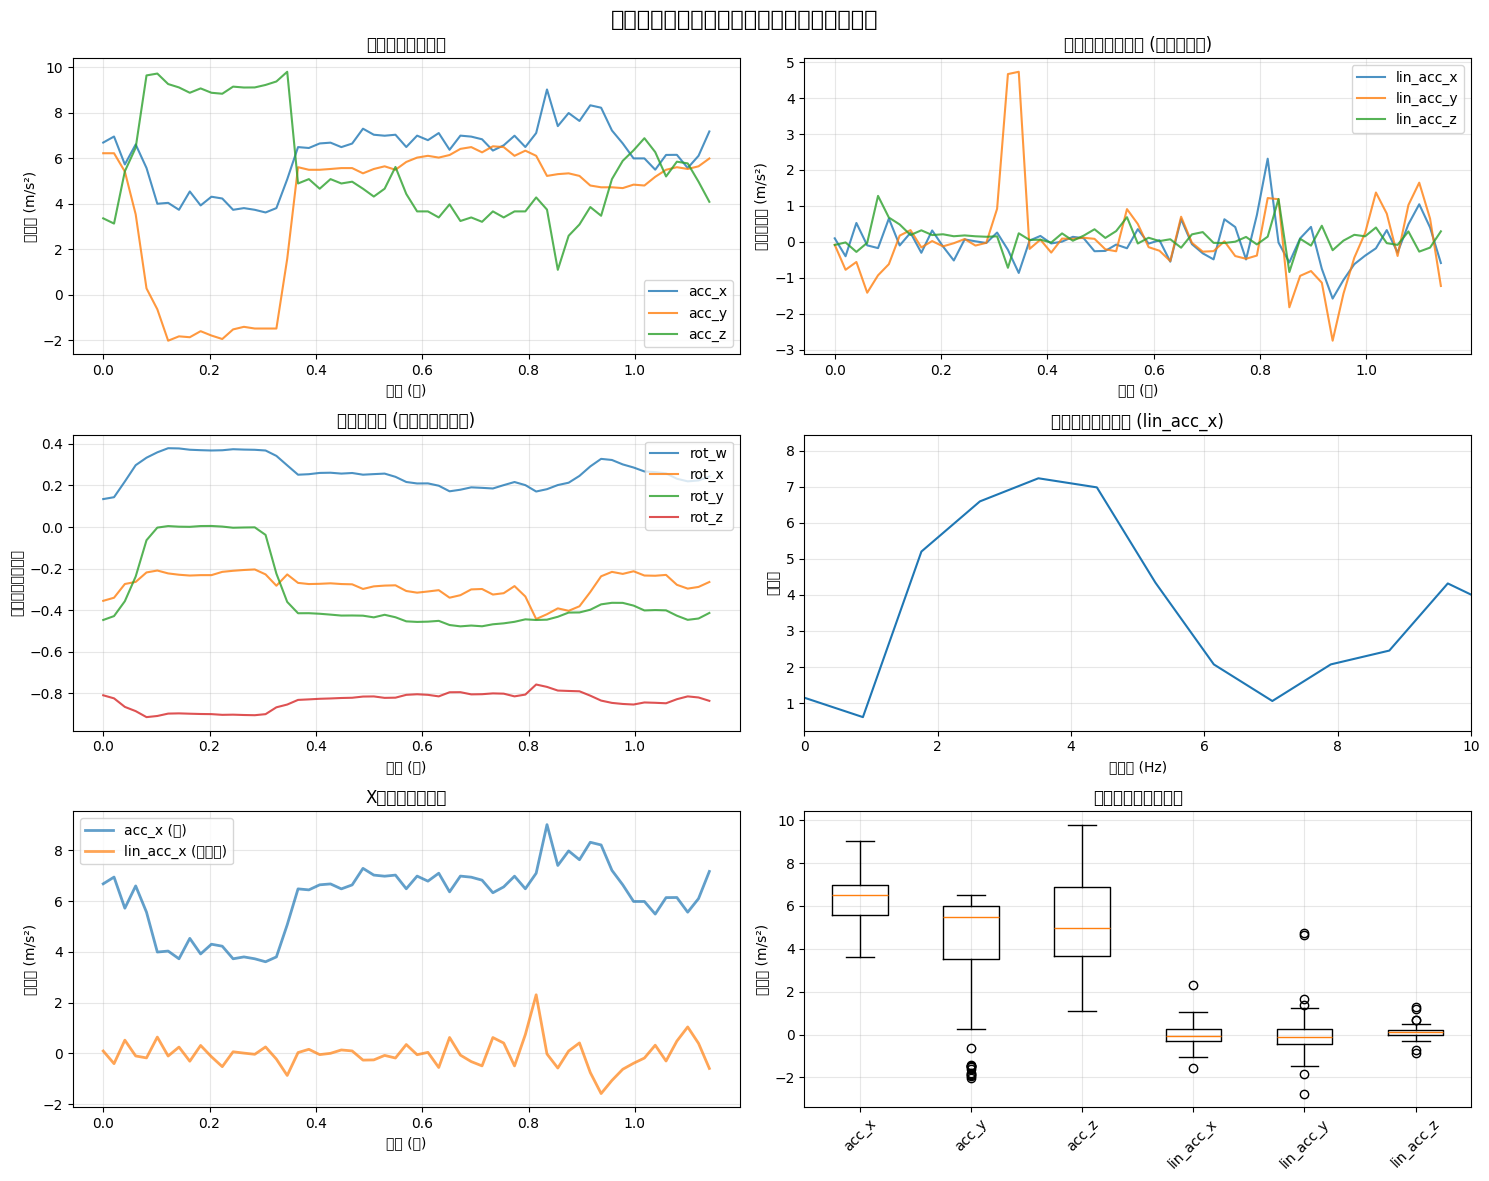

\n============================================================
前処理可視化ノート完了


In [11]:
# エラー修正版: データの可視化
print("="*60)
print("データ可視化 (エラー修正版)")
print("="*60)

if 'test_data' in locals() and len(test_data) > 0:
    # 時間軸の作成
    n_samples = len(test_data)
    time_axis = np.linspace(0, n_samples/fs, n_samples)
    
    # 図を作成
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('実際のセンサーデータと前処理結果の可視化', fontsize=16)
    
    # 1. 元の加速度データ
    axes[0,0].plot(time_axis, test_data['acc_x'], label='acc_x', alpha=0.8)
    axes[0,0].plot(time_axis, test_data['acc_y'], label='acc_y', alpha=0.8)
    axes[0,0].plot(time_axis, test_data['acc_z'], label='acc_z', alpha=0.8)
    axes[0,0].set_title('元の加速度データ')
    axes[0,0].set_xlabel('時間 (秒)')
    axes[0,0].set_ylabel('加速度 (m/s²)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. 線形加速度データ
    if 'lin_acc_x' in test_data.columns:
        axes[0,1].plot(time_axis, test_data['lin_acc_x'], label='lin_acc_x', alpha=0.8)
        axes[0,1].plot(time_axis, test_data['lin_acc_y'], label='lin_acc_y', alpha=0.8)
        axes[0,1].plot(time_axis, test_data['lin_acc_z'], label='lin_acc_z', alpha=0.8)
    axes[0,1].set_title('線形加速度データ (重力除去後)')
    axes[0,1].set_xlabel('時間 (秒)')
    axes[0,1].set_ylabel('線形加速度 (m/s²)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. 姿勢データ (クォータニオン)
    axes[1,0].plot(time_axis, test_data['rot_w'], label='rot_w', alpha=0.8)
    axes[1,0].plot(time_axis, test_data['rot_x'], label='rot_x', alpha=0.8)
    axes[1,0].plot(time_axis, test_data['rot_y'], label='rot_y', alpha=0.8)
    axes[1,0].plot(time_axis, test_data['rot_z'], label='rot_z', alpha=0.8)
    axes[1,0].set_title('姿勢データ (クォータニオン)')
    axes[1,0].set_xlabel('時間 (秒)')
    axes[1,0].set_ylabel('クォータニオン値')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. FFTスペクトル (エラーハンドリング付き)
    if 'lin_acc_x' in test_data.columns:
        from scipy.fft import fft, fftfreq
        
        # lin_acc_xのFFTスペクトルを計算
        signal = test_data['lin_acc_x'].to_numpy()
        if len(signal) > 0:  # データが存在する場合のみFFT計算
            try:
                fft_vals = np.abs(fft(signal))
                freqs = fftfreq(len(signal), d=1/fs)
                
                # 正の周波数のみ表示
                positive_freqs = freqs[:len(freqs)//2]
                positive_fft = fft_vals[:len(fft_vals)//2]
                
                axes[1,1].plot(positive_freqs, positive_fft)
                axes[1,1].set_title('周波数スペクトル (lin_acc_x)')
                axes[1,1].set_xlabel('周波数 (Hz)')
                axes[1,1].set_ylabel('パワー')
                axes[1,1].grid(True, alpha=0.3)
                axes[1,1].set_xlim(0, 10)  # 0-10Hzに焦点
            except Exception as e:
                print(f"FFT計算エラー: {e}")
                axes[1,1].text(0.5, 0.5, 'FFT計算エラー', ha='center', va='center', transform=axes[1,1].transAxes)
                axes[1,1].set_title('周波数スペクトル (エラー)')
        else:
            axes[1,1].text(0.5, 0.5, 'データなし', ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('周波数スペクトル (データなし)')
    
    # 5. 比較プロット (元vs線形加速度)
    if 'lin_acc_x' in test_data.columns:
        axes[2,0].plot(time_axis, test_data['acc_x'], label='acc_x (元)', alpha=0.7, linewidth=2)
        axes[2,0].plot(time_axis, test_data['lin_acc_x'], label='lin_acc_x (処理後)', alpha=0.7, linewidth=2)
        axes[2,0].set_title('X軸加速度の比較')
        axes[2,0].set_xlabel('時間 (秒)')
        axes[2,0].set_ylabel('加速度 (m/s²)')
        axes[2,0].legend()
        axes[2,0].grid(True, alpha=0.3)
    
    # 6. 統計ボックスプロット
    if 'stats_results' in locals():
        stats_data = []
        labels = []
        for axis in ['acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z']:
            if axis in test_data.columns:
                stats_data.append(test_data[axis].to_numpy())
                labels.append(axis)
        
        if stats_data:
            bp = axes[2,1].boxplot(stats_data, labels=labels)
            axes[2,1].set_title('加速度データの分布')
            axes[2,1].set_ylabel('加速度 (m/s²)')
            axes[2,1].tick_params(axis='x', rotation=45)
            axes[2,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # FFTバンドエネルギーの可視化
    if 'fft_energy' in locals() and fft_energy is not None:
        print("\\nFFTバンドエネルギーの詳細:")
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        band_names = [f"{band[0]}-{band[1]}Hz" for band in params['fft_bands']]
        energy_per_band = []
        
        for i in range(len(params['fft_bands'])):
            # 各バンドの3軸のエネルギーを合計
            band_energy = np.sum(fft_energy[0, i*3:(i+1)*3])
            energy_per_band.append(band_energy)
        
        bars = ax.bar(band_names, energy_per_band, alpha=0.7, color='skyblue')
        ax.set_title('周波数バンド別エネルギー分布')
        ax.set_xlabel('周波数バンド')
        ax.set_ylabel('エネルギー')
        ax.grid(True, alpha=0.3)
        
        # バーの上に値を表示
        for bar, energy in zip(bars, energy_per_band):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{energy:.0f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

else:
    print("テストデータが利用できません")

print("\\n" + "="*60)
print("前処理可視化ノート完了")
print("="*60)

データ可視化


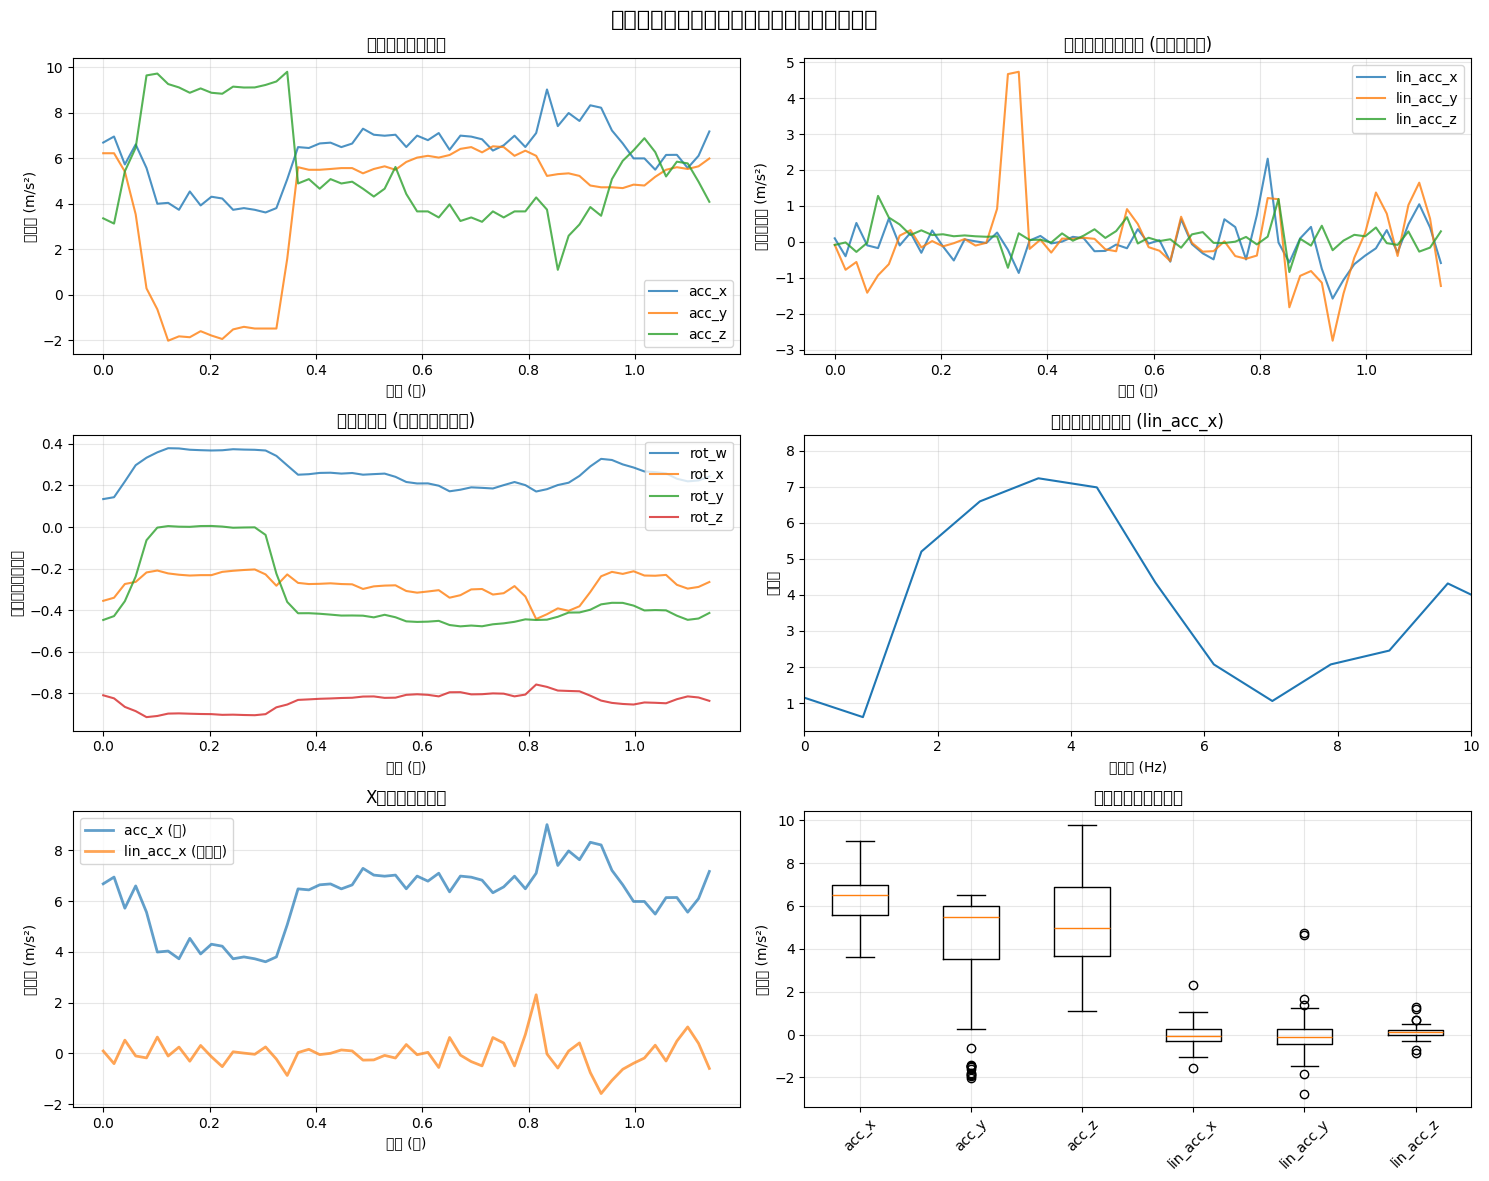

In [6]:
# データの可視化
print("="*60)
print("データ可視化")
print("="*60)

if 'test_data' in locals() and len(test_data) > 0:
    # 時間軸の作成
    n_samples = len(test_data)
    time_axis = np.linspace(0, n_samples/fs, n_samples)
    
    # 図を作成
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('実際のセンサーデータと前処理結果の可視化', fontsize=16)
    
    # 1. 元の加速度データ
    axes[0,0].plot(time_axis, test_data['acc_x'], label='acc_x', alpha=0.8)
    axes[0,0].plot(time_axis, test_data['acc_y'], label='acc_y', alpha=0.8)
    axes[0,0].plot(time_axis, test_data['acc_z'], label='acc_z', alpha=0.8)
    axes[0,0].set_title('元の加速度データ')
    axes[0,0].set_xlabel('時間 (秒)')
    axes[0,0].set_ylabel('加速度 (m/s²)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. 線形加速度データ
    if 'lin_acc_x' in test_data.columns:
        axes[0,1].plot(time_axis, test_data['lin_acc_x'], label='lin_acc_x', alpha=0.8)
        axes[0,1].plot(time_axis, test_data['lin_acc_y'], label='lin_acc_y', alpha=0.8)
        axes[0,1].plot(time_axis, test_data['lin_acc_z'], label='lin_acc_z', alpha=0.8)
    axes[0,1].set_title('線形加速度データ (重力除去後)')
    axes[0,1].set_xlabel('時間 (秒)')
    axes[0,1].set_ylabel('線形加速度 (m/s²)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. 姿勢データ (クォータニオン)
    axes[1,0].plot(time_axis, test_data['rot_w'], label='rot_w', alpha=0.8)
    axes[1,0].plot(time_axis, test_data['rot_x'], label='rot_x', alpha=0.8)
    axes[1,0].plot(time_axis, test_data['rot_y'], label='rot_y', alpha=0.8)
    axes[1,0].plot(time_axis, test_data['rot_z'], label='rot_z', alpha=0.8)
    axes[1,0].set_title('姿勢データ (クォータニオン)')
    axes[1,0].set_xlabel('時間 (秒)')
    axes[1,0].set_ylabel('クォータニオン値')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. FFTスペクトル
    if 'lin_acc_x' in test_data.columns:
        from scipy.fft import fft, fftfreq
        
        # lin_acc_xのFFTスペクトルを計算
        signal = test_data['lin_acc_x'].values
        fft_vals = np.abs(fft(signal))
        freqs = fftfreq(len(signal), d=1/fs)
        
        # 正の周波数のみ表示
        positive_freqs = freqs[:len(freqs)//2]
        positive_fft = fft_vals[:len(fft_vals)//2]
        
        axes[1,1].plot(positive_freqs, positive_fft)
        axes[1,1].set_title('周波数スペクトル (lin_acc_x)')
        axes[1,1].set_xlabel('周波数 (Hz)')
        axes[1,1].set_ylabel('パワー')
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].set_xlim(0, 10)  # 0-10Hzに焦点
    
    # 5. 比較プロット (元vs線形加速度)
    if 'lin_acc_x' in test_data.columns:
        axes[2,0].plot(time_axis, test_data['acc_x'], label='acc_x (元)', alpha=0.7, linewidth=2)
        axes[2,0].plot(time_axis, test_data['lin_acc_x'], label='lin_acc_x (処理後)', alpha=0.7, linewidth=2)
        axes[2,0].set_title('X軸加速度の比較')
        axes[2,0].set_xlabel('時間 (秒)')
        axes[2,0].set_ylabel('加速度 (m/s²)')
        axes[2,0].legend()
        axes[2,0].grid(True, alpha=0.3)
    
    # 6. 統計ボックスプロット
    if 'stats_results' in locals():
        stats_data = []
        labels = []
        for axis in ['acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z']:
            if axis in test_data.columns:
                stats_data.append(test_data[axis].values)
                labels.append(axis)
        
        if stats_data:
            bp = axes[2,1].boxplot(stats_data, labels=labels)
            axes[2,1].set_title('加速度データの分布')
            axes[2,1].set_ylabel('加速度 (m/s²)')
            axes[2,1].tick_params(axis='x', rotation=45)
            axes[2,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # FFTバンドエネルギーの可視化
    if 'fft_energy' in locals() and fft_energy is not None:
        print("\\nFFTバンドエネルギーの詳細:")
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        band_names = [f"{band[0]}-{band[1]}Hz" for band in params['fft_bands']]
        energy_per_band = []
        
        for i in range(len(params['fft_bands'])):
            # 各バンドの3軸のエネルギーを合計
            band_energy = np.sum(fft_energy[0, i*3:(i+1)*3])
            energy_per_band.append(band_energy)
        
        bars = ax.bar(band_names, energy_per_band, alpha=0.7, color='skyblue')
        ax.set_title('周波数バンド別エネルギー分布')
        ax.set_xlabel('周波数バンド')
        ax.set_ylabel('エネルギー')
        ax.grid(True, alpha=0.3)
        
        # バーの上に値を表示
        for bar, energy in zip(bars, energy_per_band):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{energy:.0f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

else:
    print("テストデータが利用できません")


複数ジェスチャーの比較分析
\n比較対象ジェスチャー数: 18


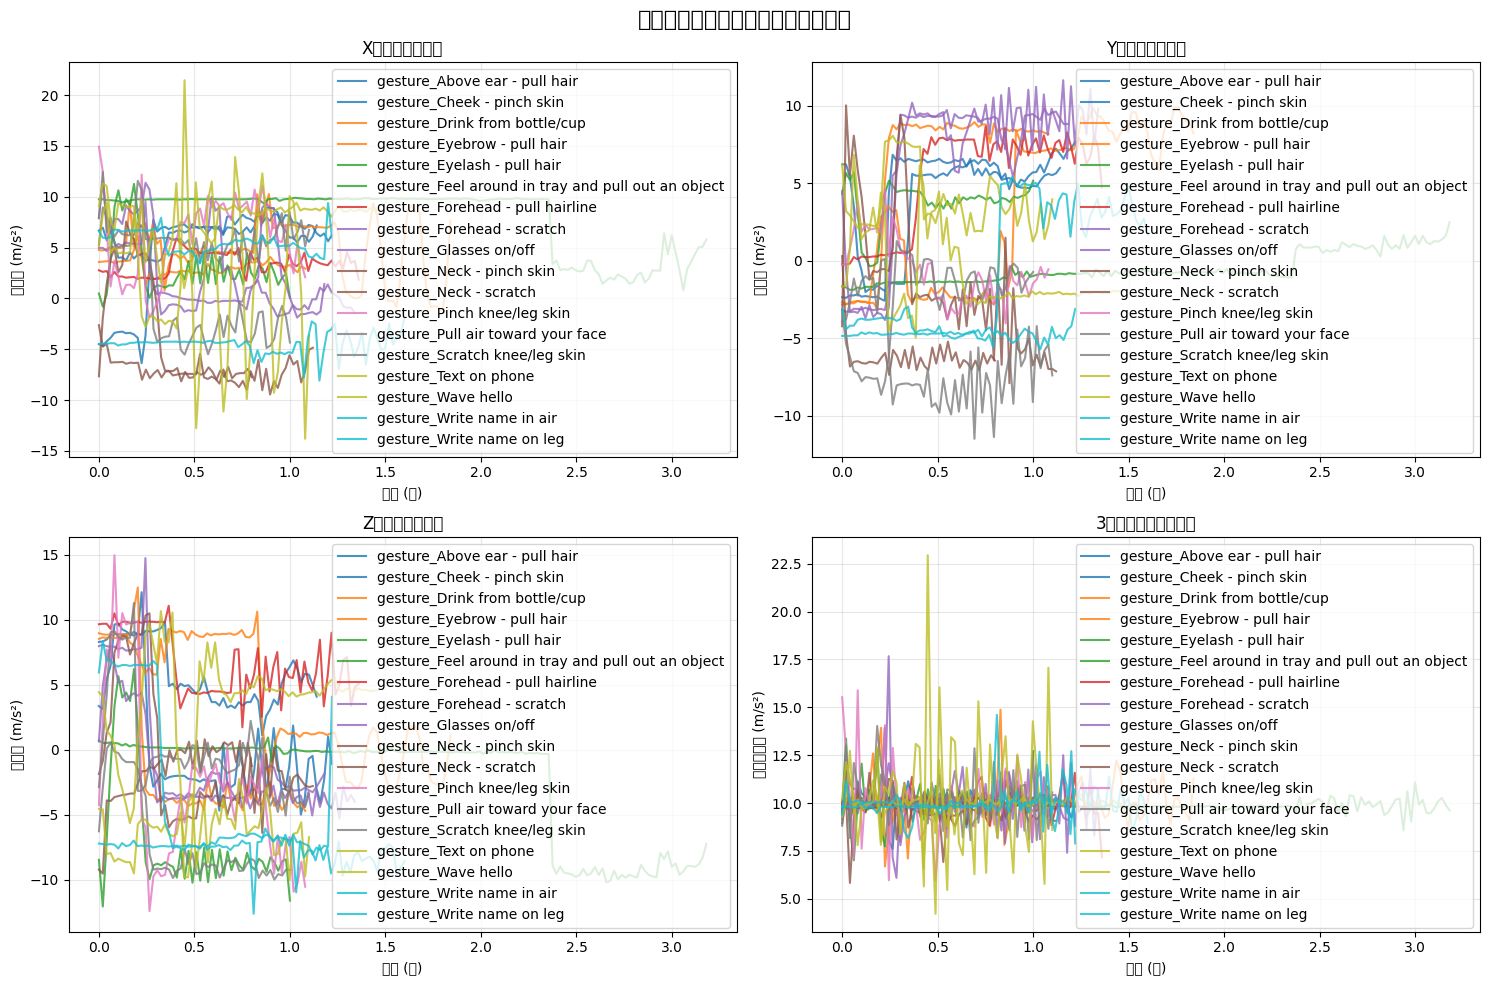

\nジェスチャー別統計比較:
                                                    acc_x_std  acc_y_std  \
gesture_Above ear - pull hair                           4.670      3.424   
gesture_Cheek - pinch skin                              1.322      3.021   
gesture_Drink from bottle/cup                           2.816      4.976   
gesture_Eyebrow - pull hair                             0.741      4.456   
gesture_Eyelash - pull hair                             2.866      1.390   
gesture_Feel around in tray and pull out an object      3.015      0.973   
gesture_Forehead - pull hairline                        1.079      3.244   
gesture_Forehead - scratch                              2.410      4.966   
gesture_Glasses on/off                                  4.471      4.872   
gesture_Neck - pinch skin                               1.038      1.179   
gesture_Neck - scratch                                  5.048      4.389   
gesture_Pinch knee/leg skin                             3.821      1.951 

In [7]:
# 複数ジェスチャーの比較
print("="*60)
print("複数ジェスチャーの比較分析")
print("="*60)

if 'df' in locals() and len(df) > 0:
    # 各ジェスチャーから代表的なシーケンスを選択
    gesture_comparison = {}
    
    for gesture in sorted(df['gesture'].unique()):
        gesture_data = df[df['gesture'] == gesture]
        # 最初のシーケンスを選択
        first_sequence = gesture_data['sequence_id'].iloc[0]
        seq_data = gesture_data[gesture_data['sequence_id'] == first_sequence].copy()
        
        # 一定の長さに統一（短いデータは延長、長いデータは切り詰め）
        target_length = min(200, len(seq_data))  # 最大200サンプル
        if len(seq_data) >= target_length:
            seq_data = seq_data.iloc[:target_length]
        
        gesture_comparison[f'gesture_{gesture}'] = seq_data
    
    print(f"\\n比較対象ジェスチャー数: {len(gesture_comparison)}")
    
    # 比較プロット作成
    n_gestures = len(gesture_comparison)
    if n_gestures > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('ジェスチャー別センサーデータ比較', fontsize=16)
        
        colors = plt.cm.tab10(np.linspace(0, 1, n_gestures))
        
        # 1. X軸加速度の比較
        for i, (gesture_name, data) in enumerate(gesture_comparison.items()):
            time_axis = np.linspace(0, len(data)/fs, len(data))
            axes[0,0].plot(time_axis, data['acc_x'], 
                          label=gesture_name, color=colors[i], alpha=0.8)
        axes[0,0].set_title('X軸加速度の比較')
        axes[0,0].set_xlabel('時間 (秒)')
        axes[0,0].set_ylabel('加速度 (m/s²)')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Y軸加速度の比較
        for i, (gesture_name, data) in enumerate(gesture_comparison.items()):
            time_axis = np.linspace(0, len(data)/fs, len(data))
            axes[0,1].plot(time_axis, data['acc_y'], 
                          label=gesture_name, color=colors[i], alpha=0.8)
        axes[0,1].set_title('Y軸加速度の比較')
        axes[0,1].set_xlabel('時間 (秒)')
        axes[0,1].set_ylabel('加速度 (m/s²)')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Z軸加速度の比較
        for i, (gesture_name, data) in enumerate(gesture_comparison.items()):
            time_axis = np.linspace(0, len(data)/fs, len(data))
            axes[1,0].plot(time_axis, data['acc_z'], 
                          label=gesture_name, color=colors[i], alpha=0.8)
        axes[1,0].set_title('Z軸加速度の比較')
        axes[1,0].set_xlabel('時間 (秒)')
        axes[1,0].set_ylabel('加速度 (m/s²)')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # 4. 3軸合成加速度の比較
        for i, (gesture_name, data) in enumerate(gesture_comparison.items()):
            time_axis = np.linspace(0, len(data)/fs, len(data))
            magnitude = np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)
            axes[1,1].plot(time_axis, magnitude, 
                          label=gesture_name, color=colors[i], alpha=0.8)
        axes[1,1].set_title('3軸合成加速度の比較')
        axes[1,1].set_xlabel('時間 (秒)')
        axes[1,1].set_ylabel('合成加速度 (m/s²)')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 統計的比較
        print("\\nジェスチャー別統計比較:")
        stats_comparison = {}
        
        for gesture_name, data in gesture_comparison.items():
            stats_comparison[gesture_name] = {
                'acc_x_std': np.std(data['acc_x']),
                'acc_y_std': np.std(data['acc_y']),
                'acc_z_std': np.std(data['acc_z']),
                'acc_magnitude_mean': np.mean(np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)),
                'data_length': len(data)
            }
        
        # 統計をDataFrameで表示
        stats_df = pd.DataFrame(stats_comparison).T
        print(stats_df.round(3))
        
        # Demographics情報があれば表示
        if 'handedness' in df.columns:
            print("\\nジェスチャー別Demographics情報:")
            demo_comparison = {}
            
            for gesture in sorted(df['gesture'].unique()):
                gesture_data = df[df['gesture'] == gesture]
                demo_comparison[f'gesture_{gesture}'] = {
                    'handedness_mode': gesture_data['handedness'].mode().iloc[0] if len(gesture_data['handedness'].mode()) > 0 else 'N/A',
                    'unique_subjects': gesture_data['subject'].nunique(),
                    'total_samples': len(gesture_data)
                }
            
            demo_df = pd.DataFrame(demo_comparison).T
            print(demo_df)

else:
    print("データが利用できません")

print("\\n" + "="*60)
print("前処理可視化ノート完了")
print("="*60)


D. ワールド線形加速度（姿勢補正と重力除去）の検証


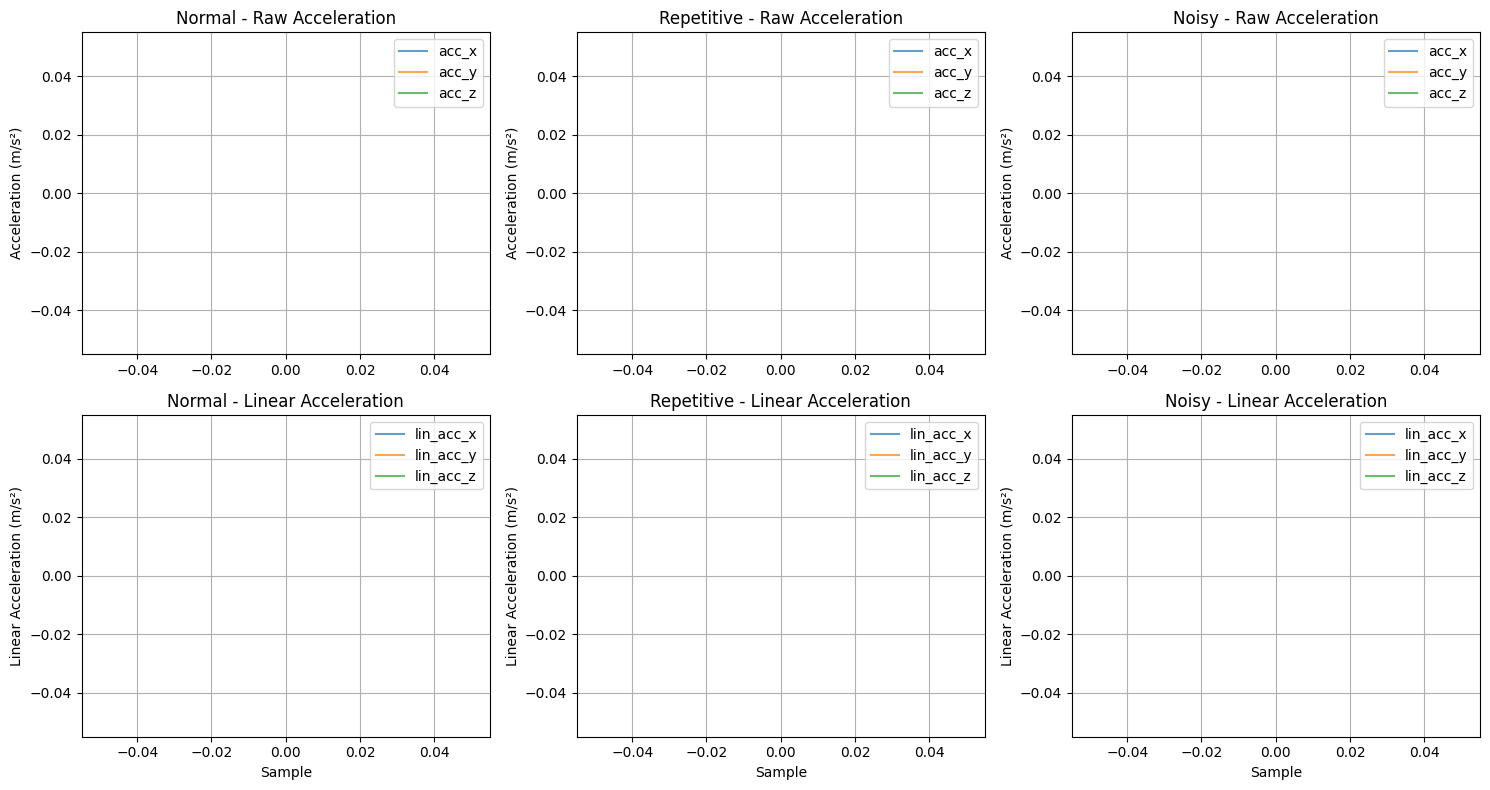

\n重力除去の効果:
\nNormal:
  Raw acceleration std: [nan nan nan]
  Linear acceleration std: [nan nan nan]
  Z軸の平均（重力成分確認）:
    Raw acc_z mean: nan
    Linear acc_z mean: nan
\nRepetitive:
  Raw acceleration std: [nan nan nan]
  Linear acceleration std: [nan nan nan]
  Z軸の平均（重力成分確認）:
    Raw acc_z mean: nan
    Linear acc_z mean: nan
\nNoisy:
  Raw acceleration std: [nan nan nan]
  Linear acceleration std: [nan nan nan]
  Z軸の平均（重力成分確認）:
    Raw acc_z mean: nan
    Linear acc_z mean: nan


In [8]:
print("="*60)
print("D. ワールド線形加速度（姿勢補正と重力除去）の検証")
print("="*60)

# 各シーケンスに対して線形加速度を計算
sensor_cols = ['acc_x', 'acc_y', 'acc_z']
quat_cols = ['rot_w', 'rot_x', 'rot_y', 'rot_z']

# 全データに対して線形加速度を計算
lin_acc_results = []
for _, row in df.iterrows():
    acc = row[sensor_cols].values
    quat = row[quat_cols].values
    lin_acc = preprocessing.linear_acceleration(acc, quat)
    lin_acc_results.append(lin_acc)

lin_acc_array = np.array(lin_acc_results)
df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']] = lin_acc_array

# 元の加速度と線形加速度の比較
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, pattern in enumerate(['normal', 'repetitive', 'noisy']):
    pattern_data = df[df['gesture'] == i].iloc[:window_size]
    
    # 元の加速度
    axes[0, i].plot(pattern_data['acc_x'], label='acc_x', alpha=0.7)
    axes[0, i].plot(pattern_data['acc_y'], label='acc_y', alpha=0.7)
    axes[0, i].plot(pattern_data['acc_z'], label='acc_z', alpha=0.7)
    axes[0, i].set_title(f'{gesture_names[i]} - Raw Acceleration')
    axes[0, i].legend()
    axes[0, i].grid(True)
    axes[0, i].set_ylabel('Acceleration (m/s²)')
    
    # 線形加速度（重力除去後）
    axes[1, i].plot(pattern_data['lin_acc_x'], label='lin_acc_x', alpha=0.7)
    axes[1, i].plot(pattern_data['lin_acc_y'], label='lin_acc_y', alpha=0.7)
    axes[1, i].plot(pattern_data['lin_acc_z'], label='lin_acc_z', alpha=0.7)
    axes[1, i].set_title(f'{gesture_names[i]} - Linear Acceleration')
    axes[1, i].legend()
    axes[1, i].grid(True)
    axes[1, i].set_ylabel('Linear Acceleration (m/s²)')
    axes[1, i].set_xlabel('Sample')

plt.tight_layout()
plt.show()

# 統計比較
print("\\n重力除去の効果:")
for gesture in range(3):
    gesture_data = df[df['gesture'] == gesture]
    raw_std = gesture_data[['acc_x', 'acc_y', 'acc_z']].std()
    lin_std = gesture_data[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']].std()
    
    print(f"\\n{gesture_names[gesture]}:")
    print(f"  Raw acceleration std: {raw_std.values}")
    print(f"  Linear acceleration std: {lin_std.values}")
    print(f"  Z軸の平均（重力成分確認）:")
    print(f"    Raw acc_z mean: {gesture_data['acc_z'].mean():.2f}")
    print(f"    Linear acc_z mean: {gesture_data['lin_acc_z'].mean():.2f}")

In [ ]:
print("="*60)
print("A. 基本統計（Mean, Std, Max, Min, Range, RMS）の検証")
print("="*60)

# スライディングウィンドウの作成
sensor_cols = ['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'acc_x', 'acc_y', 'acc_z']
demographics_cols = ['handedness', 'height_cm', 'shoulder_to_wrist_cm', 'sex']

X_sensor, X_demographics, y, sequence_info = preprocessing.create_sliding_windows_with_demographics(
    df, 
    window_size=window_size, 
    stride=stride,
    sensor_cols=sensor_cols,
    demographics_cols=demographics_cols,
    min_sequence_length=10
)

print(f"作成されたウィンドウ数: {len(X_sensor)}")
print(f"センサーデータ形状: {X_sensor.shape}")
print(f"Demographics形状: {X_demographics.shape}")
# print(f"ラベル分布: {np.bincount(y)}")
print(f"Label dtype: {y.dtype}")
print(f"Label sample: {y[:5]}")
# 文字列ラベルを数値に変換
if y.dtype == 'object' or y.dtype.kind in ['U', 'S']:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_numeric = le.fit_transform(y)
    print(f"Label distribution (numeric): {np.bincount(y_numeric)}")
    print(f"Label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
else:
    y_numeric = y
    print(f"Label distribution: {np.bincount(y_numeric)}")
    
# 基本統計の計算
basic_stats = preprocessing.compute_basic_statistics(X_sensor)
print(f"\\n基本統計特徴量の形状: {basic_stats.shape}")

# 特徴量の内容確認
feature_names = []
for col in sensor_cols:
    feature_names.extend([
        f"{col}_mean", f"{col}_std", f"{col}_range", f"{col}_rms", f"{col}_energy"
    ])
feature_names.extend(["mag_mean", "mag_std"])  # 3D magnitude features

print(f"\\n特徴量数: {len(feature_names)} (expected: {basic_stats.shape[1]})")

# 統計の可視化
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Mean values by gesture
stats_df = pd.DataFrame(basic_stats[:, :len(sensor_cols)], columns=[f"{col}_mean" for col in sensor_cols])
stats_df['gesture'] = y
mean_by_gesture = stats_df.groupby('gesture').mean()

mean_by_gesture.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Mean Values by Gesture')
axes[0, 0].set_ylabel('Mean Acceleration')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Std values by gesture
std_start = len(sensor_cols)
std_df = pd.DataFrame(basic_stats[:, std_start:std_start+len(sensor_cols)], 
                     columns=[f"{col}_std" for col in sensor_cols])
std_df['gesture'] = y
std_by_gesture = std_df.groupby('gesture').mean()

std_by_gesture.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Std Values by Gesture')
axes[0, 1].set_ylabel('Std Acceleration')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# RMS values by gesture
rms_start = len(sensor_cols) * 3  # mean, std, range
rms_df = pd.DataFrame(basic_stats[:, rms_start:rms_start+len(sensor_cols)], 
                     columns=[f"{col}_rms" for col in sensor_cols])
rms_df['gesture'] = y
rms_by_gesture = rms_df.groupby('gesture').mean()

rms_by_gesture.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('RMS Values by Gesture')
axes[1, 0].set_ylabel('RMS Acceleration')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3D magnitude stats
mag_stats = basic_stats[:, -2:]  # last 2 features are magnitude mean and std
mag_df = pd.DataFrame(mag_stats, columns=['mag_mean', 'mag_std'])
mag_df['gesture'] = y
mag_by_gesture = mag_df.groupby('gesture').mean()

mag_by_gesture.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('3D Magnitude Stats by Gesture')
axes[1, 1].set_ylabel('Magnitude')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\\n基本統計の要約:")
for gesture in range(3):
    mask = y == gesture
    gesture_stats = basic_stats[mask]
    print(f"\\n{gesture_names[gesture]}:")
    print(f"  統計値の平均: {gesture_stats.mean(axis=0)[:5].round(3)}")  # 最初5つの特徴量
    print(f"  統計値の標準偏差: {gesture_stats.std(axis=0)[:5].round(3)}")


A. 基本統計（Mean, Std, Max, Min, Range, RMS）の検証
作成されたウィンドウ数: 54
センサーデータ形状: (54, 256, 6)
Demographics形状: (54, 4)


TypeError: Cannot cast array data from dtype('<U42') to dtype('int64') according to the rule 'safe'

B. ピーク & 周期（ピーク数、ゼロ交差数等）の検証
ピーク特徴量の形状: (6, 6)


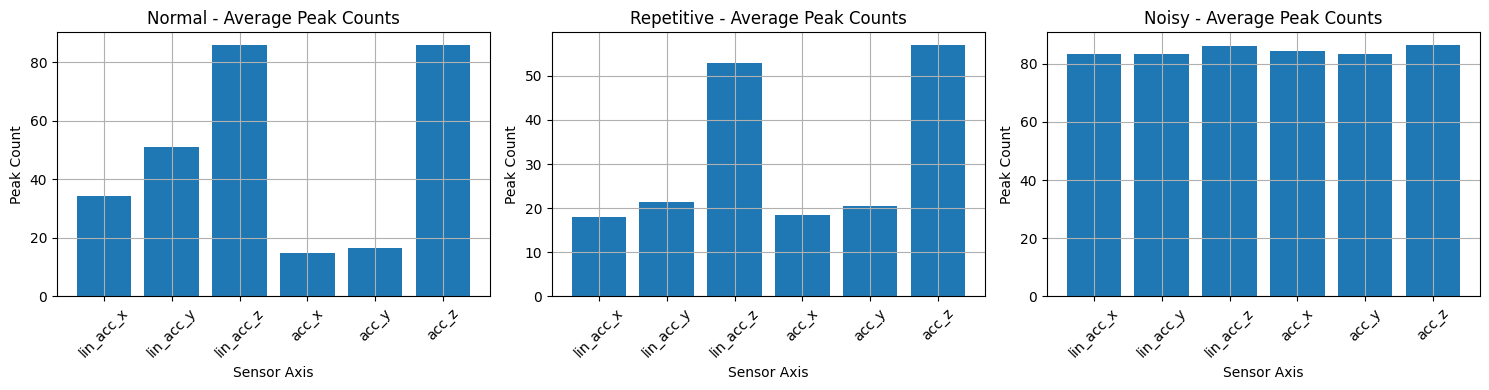

\nピーク特徴量の統計:
\nNormal:
  平均ピーク数: [34.5 51.  86.  15.  16.5 86. ]
  ピーク数の標準偏差: [3.5 1.  1.  1.  2.5 1. ]
\nRepetitive:
  平均ピーク数: [18.  21.5 53.  18.5 20.5 57. ]
  ピーク数の標準偏差: [1.  1.5 5.  0.5 1.5 5. ]
\nNoisy:
  平均ピーク数: [83.5 83.5 86.  84.5 83.5 86.5]
  ピーク数の標準偏差: [3.5 2.5 4.  2.5 1.5 5.5]
\n============================================================
C. FFT / 周波数（周波数バンドエネルギー）の検証
FFTバンドエネルギーの形状: (6, 24)
周波数バンド: [[0.5, 2], [2, 5], [5, 10], [10, 20]]


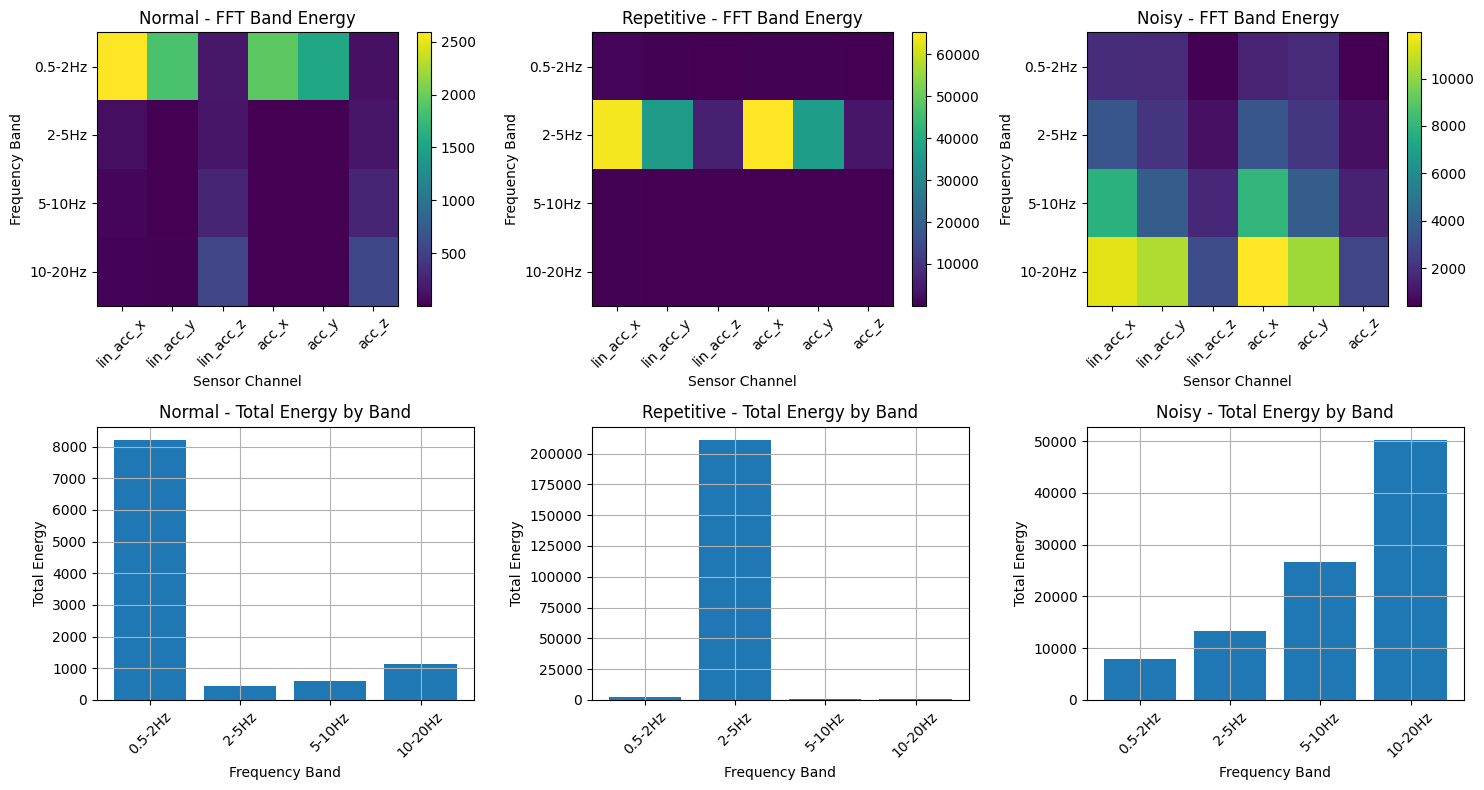

\nFFT特徴量の統計:
\nNormal:
  総エネルギー平均: 10378.49
  総エネルギー標準偏差: 428.30
  バンドごとの平均エネルギー:
    0.5-2Hz: 8217.92
    2-5Hz: 438.95
    5-10Hz: 587.93
    10-20Hz: 1133.70
\nRepetitive:
  総エネルギー平均: 215632.06
  総エネルギー標準偏差: 1844.78
  バンドごとの平均エネルギー:
    0.5-2Hz: 2291.17
    2-5Hz: 211338.19
    5-10Hz: 942.52
    10-20Hz: 1060.17
\nNoisy:
  総エネルギー平均: 98142.82
  総エネルギー標準偏差: 4239.68
  バンドごとの平均エネルギー:
    0.5-2Hz: 7914.93
    2-5Hz: 13290.95
    5-10Hz: 26641.47
    10-20Hz: 50295.47


In [ ]:
print("="*60)
print("B. ピーク & 周期（ピーク数、ゼロ交差数等）の検証")
print("="*60)

# ピーク特徴量の計算
peak_features = preprocessing.compute_peak_features(X_sensor)
print(f"ピーク特徴量の形状: {peak_features.shape}")

# ピーク特徴量の可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, gesture in enumerate(range(3)):
    mask = y == gesture
    gesture_peaks = peak_features[mask]
    
    # 各軸のピーク数の平均
    avg_peaks = gesture_peaks.mean(axis=0)
    
    axes[i].bar(range(len(avg_peaks)), avg_peaks)
    axes[i].set_title(f'{gesture_names[gesture]} - Average Peak Counts')
    axes[i].set_xlabel('Sensor Axis')
    axes[i].set_ylabel('Peak Count')
    axes[i].set_xticks(range(len(sensor_cols)))
    axes[i].set_xticklabels(sensor_cols, rotation=45)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# ピーク特徴量の統計
print("\\nピーク特徴量の統計:")
for gesture in range(3):
    mask = y == gesture
    gesture_peaks = peak_features[mask]
    print(f"\\n{gesture_names[gesture]}:")
    print(f"  平均ピーク数: {gesture_peaks.mean(axis=0).round(2)}")
    print(f"  ピーク数の標準偏差: {gesture_peaks.std(axis=0).round(2)}")

print("\\n" + "="*60)
print("C. FFT / 周波数（周波数バンドエネルギー）の検証")
print("="*60)

# FFTバンドエネルギーの計算
bands = params['fft_bands']
fft_energy = preprocessing.compute_fft_band_energy(X_sensor, fs=fs, bands=bands)
print(f"FFTバンドエネルギーの形状: {fft_energy.shape}")
print(f"周波数バンド: {bands}")

# FFT特徴量の可視化
n_bands = len(bands)
n_features = len(sensor_cols)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 各ジェスチャーのFFTエネルギー分布
for gesture in range(3):
    mask = y == gesture
    gesture_fft = fft_energy[mask]
    
    # バンドごとのエネルギー平均
    avg_energy = gesture_fft.mean(axis=0)
    
    # reshape to (n_bands, n_features)
    energy_matrix = avg_energy.reshape(n_bands, n_features)
    
    # ヒートマップ
    im = axes[0, gesture].imshow(energy_matrix, aspect='auto', cmap='viridis')
    axes[0, gesture].set_title(f'{gesture_names[gesture]} - FFT Band Energy')
    axes[0, gesture].set_xlabel('Sensor Channel')
    axes[0, gesture].set_ylabel('Frequency Band')
    axes[0, gesture].set_xticks(range(n_features))
    axes[0, gesture].set_xticklabels(sensor_cols, rotation=45)
    axes[0, gesture].set_yticks(range(n_bands))
    axes[0, gesture].set_yticklabels([f'{b[0]}-{b[1]}Hz' for b in bands])
    plt.colorbar(im, ax=axes[0, gesture])
    
    # バンドごとの総エネルギー
    band_totals = energy_matrix.sum(axis=1)
    axes[1, gesture].bar(range(n_bands), band_totals)
    axes[1, gesture].set_title(f'{gesture_names[gesture]} - Total Energy by Band')
    axes[1, gesture].set_xlabel('Frequency Band')
    axes[1, gesture].set_ylabel('Total Energy')
    axes[1, gesture].set_xticks(range(n_bands))
    axes[1, gesture].set_xticklabels([f'{b[0]}-{b[1]}Hz' for b in bands], rotation=45)
    axes[1, gesture].grid(True)

plt.tight_layout()
plt.show()

# FFT特徴量の統計
print("\\nFFT特徴量の統計:")
for gesture in range(3):
    mask = y == gesture
    gesture_fft = fft_energy[mask]
    total_energy = gesture_fft.sum(axis=1)  # 各ウィンドウの総エネルギー
    
    print(f"\\n{gesture_names[gesture]}:")
    print(f"  総エネルギー平均: {total_energy.mean():.2f}")
    print(f"  総エネルギー標準偏差: {total_energy.std():.2f}")
    
    # 各バンドの平均エネルギー
    avg_energy = gesture_fft.mean(axis=0).reshape(n_bands, n_features)
    band_energies = avg_energy.sum(axis=1)
    print(f"  バンドごとの平均エネルギー:")
    for i, band in enumerate(bands):
        print(f"    {band[0]}-{band[1]}Hz: {band_energies[i]:.2f}")


E. 欠損フラグ（センサー欠損の検出）の検証


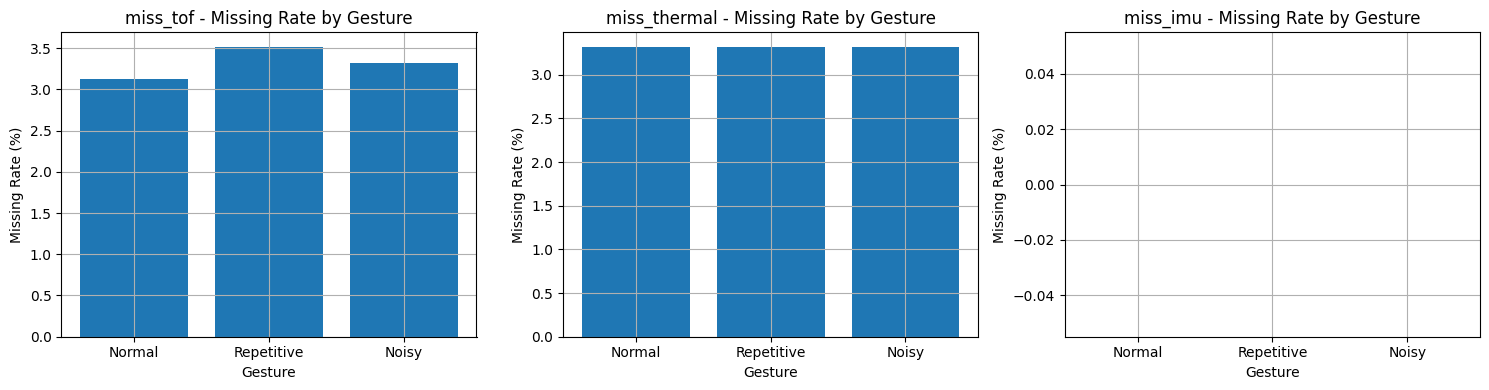

\n欠損フラグの統計:
miss_tof: 51 samples (3.3%) missing
miss_thermal: 51 samples (3.3%) missing
miss_imu: 0 samples (0.0%) missing
\n============================================================
F. Demographics（被験者属性情報）の検証


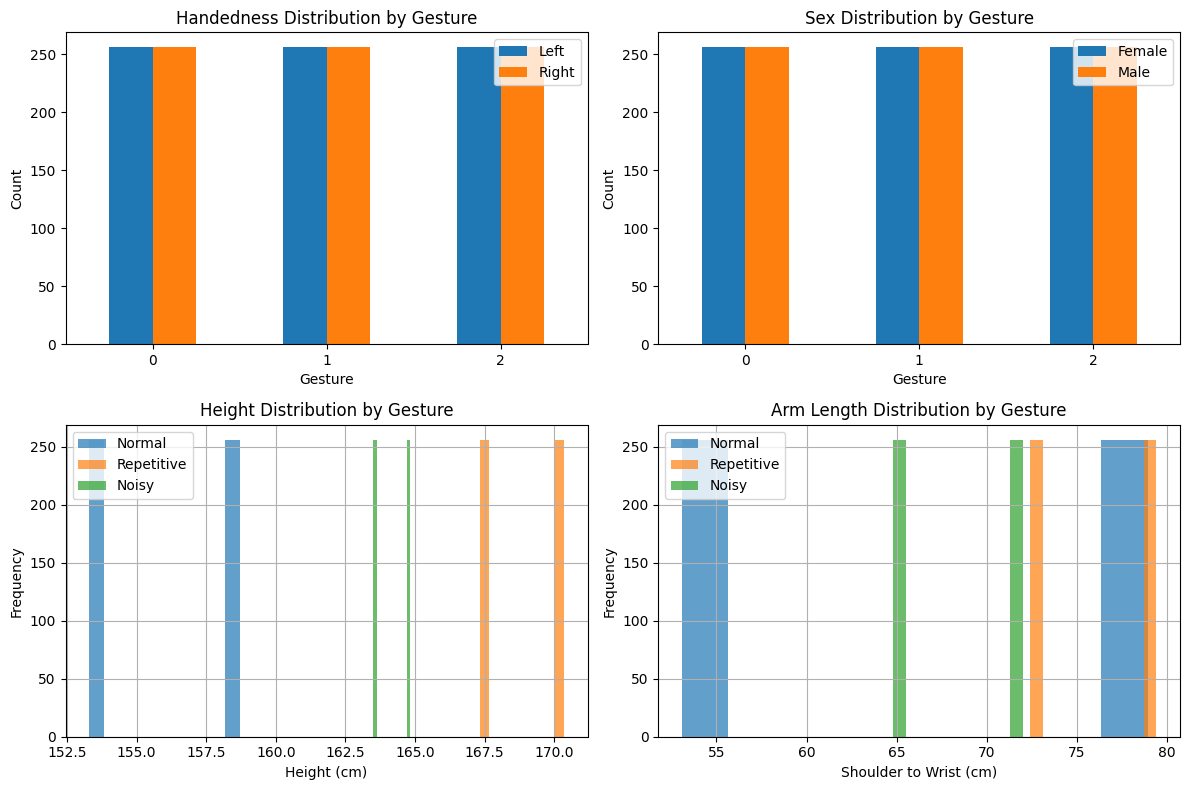

\nDemographics統計:
        handedness                                    height_cm          ...  \
             count mean  std  min  25%  50%  75%  max     count    mean  ...   
gesture                                                                  ...   
0            512.0  0.5  0.5  0.0  0.0  0.5  1.0  1.0     512.0  156.02  ...   
1            512.0  0.5  0.5  0.0  0.0  0.5  1.0  1.0     512.0  168.84  ...   
2            512.0  0.5  0.5  0.0  0.0  0.5  1.0  1.0     512.0  164.17  ...   

        shoulder_to_wrist_cm           sex                                     
                         75%    max  count mean  std  min  25%  50%  75%  max  
gesture                                                                        
0                      78.90  78.90  512.0  0.5  0.5  0.0  0.0  0.5  1.0  1.0  
1                      79.39  79.39  512.0  0.5  0.5  0.0  0.0  0.5  1.0  1.0  
2                      72.00  72.00  512.0  0.5  0.5  0.0  0.0  0.5  1.0  1.0  

[3 rows x 32 columns

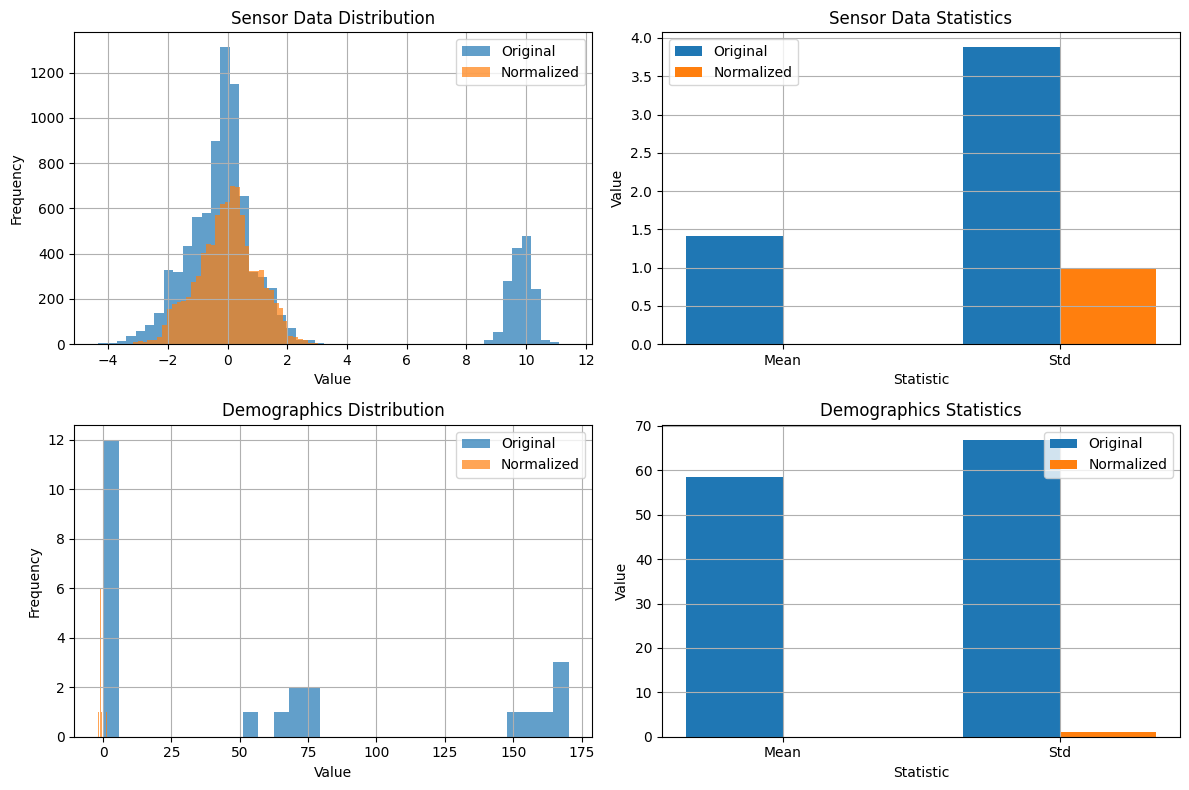

\n正規化の効果:
センサーデータ - 正規化前: mean=1.418, std=3.880
センサーデータ - 正規化後: mean=-0.000, std=1.000
Demographics - 正規化前: mean=58.525, std=66.892
Demographics - 正規化後: mean=0.000, std=1.000


In [ ]:
print("="*60)
print("E. 欠損フラグ（センサー欠損の検出）の検証")
print("="*60)

# 欠損データをシミュレート
df_with_missing = df.copy()

# 一部のデータに意図的に欠損を作成
np.random.seed(42)
missing_indices = np.random.choice(len(df_with_missing), size=int(len(df_with_missing) * 0.1), replace=False)

# ToF-like欠損フラグを追加
df_with_missing['tof_distance'] = np.random.normal(50, 10, len(df_with_missing))
df_with_missing.loc[missing_indices[:len(missing_indices)//3], 'tof_distance'] = np.nan

# Thermal-like欠損フラグを追加
df_with_missing['thermal_temp'] = np.random.normal(25, 5, len(df_with_missing))
df_with_missing.loc[missing_indices[len(missing_indices)//3:2*len(missing_indices)//3], 'thermal_temp'] = np.nan

# 欠損フラグの計算
sensor_groups = {
    'miss_tof': ['tof_distance'],
    'miss_thermal': ['thermal_temp'],
    'miss_imu': ['acc_x', 'acc_y', 'acc_z']  # IMUは通常欠損しないが例として
}

df_with_flags = preprocessing.add_missing_sensor_flags(df_with_missing, sensor_groups)

# 欠損状況の可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

flag_cols = ['miss_tof', 'miss_thermal', 'miss_imu']
for i, flag in enumerate(flag_cols):
    missing_counts = df_with_flags.groupby('gesture')[flag].sum()
    total_counts = df_with_flags.groupby('gesture').size()
    missing_rates = missing_counts / total_counts * 100
    
    axes[i].bar(range(3), missing_rates.values)
    axes[i].set_title(f'{flag} - Missing Rate by Gesture')
    axes[i].set_xlabel('Gesture')
    axes[i].set_ylabel('Missing Rate (%)')
    axes[i].set_xticks(range(3))
    axes[i].set_xticklabels(gesture_names)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

print("\\n欠損フラグの統計:")
for flag in flag_cols:
    total_missing = df_with_flags[flag].sum()
    missing_rate = total_missing / len(df_with_flags) * 100
    print(f"{flag}: {total_missing} samples ({missing_rate:.1f}%) missing")

print("\\n" + "="*60)
print("F. Demographics（被験者属性情報）の検証")
print("="*60)

# Demographics情報の可視化
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 利き手分布
handedness_counts = df.groupby(['gesture', 'handedness']).size().unstack(fill_value=0)
handedness_counts.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Handedness Distribution by Gesture')
axes[0, 0].set_xlabel('Gesture')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend(['Left', 'Right'])
axes[0, 0].tick_params(axis='x', rotation=0)

# 性別分布
sex_counts = df.groupby(['gesture', 'sex']).size().unstack(fill_value=0)
sex_counts.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Sex Distribution by Gesture')
axes[0, 1].set_xlabel('Gesture')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(['Female', 'Male'])
axes[0, 1].tick_params(axis='x', rotation=0)

# 身長分布
for gesture in range(3):
    gesture_data = df[df['gesture'] == gesture]
    axes[1, 0].hist(gesture_data['height_cm'], alpha=0.7, label=gesture_names[gesture], bins=10)
axes[1, 0].set_title('Height Distribution by Gesture')
axes[1, 0].set_xlabel('Height (cm)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 腕の長さ分布
for gesture in range(3):
    gesture_data = df[df['gesture'] == gesture]
    axes[1, 1].hist(gesture_data['shoulder_to_wrist_cm'], alpha=0.7, label=gesture_names[gesture], bins=10)
axes[1, 1].set_title('Arm Length Distribution by Gesture')
axes[1, 1].set_xlabel('Shoulder to Wrist (cm)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Demographics統計
print("\\nDemographics統計:")
demo_stats = df.groupby('gesture')[demographics_cols].describe()
print(demo_stats.round(2))

print("\\n" + "="*60)
print("正規化機能の検証")
print("="*60)

# センサーデータの正規化
X_normalized, sensor_scaler = preprocessing.normalize_sensor_data(X_sensor)
print(f"正規化前のセンサーデータ形状: {X_sensor.shape}")
print(f"正規化後のセンサーデータ形状: {X_normalized.shape}")

# Demographics正規化
X_demo_normalized, demo_scaler = preprocessing.normalize_tabular_data(X_demographics)
print(f"正規化前のDemographics形状: {X_demographics.shape}")
print(f"正規化後のDemographics形状: {X_demo_normalized.shape}")

# 正規化効果の確認
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# センサーデータの正規化前後比較
axes[0, 0].hist(X_sensor.flatten(), bins=50, alpha=0.7, label='Original')
axes[0, 0].hist(X_normalized.flatten(), bins=50, alpha=0.7, label='Normalized')
axes[0, 0].set_title('Sensor Data Distribution')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True)

# センサーデータの統計
original_stats = [X_sensor.mean(), X_sensor.std()]
normalized_stats = [X_normalized.mean(), X_normalized.std()]
stat_names = ['Mean', 'Std']

x_pos = np.arange(len(stat_names))
width = 0.35
axes[0, 1].bar(x_pos - width/2, original_stats, width, label='Original')
axes[0, 1].bar(x_pos + width/2, normalized_stats, width, label='Normalized')
axes[0, 1].set_title('Sensor Data Statistics')
axes[0, 1].set_xlabel('Statistic')
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(stat_names)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Demographics正規化前後比較
axes[1, 0].hist(X_demographics.flatten(), bins=30, alpha=0.7, label='Original')
axes[1, 0].hist(X_demo_normalized.flatten(), bins=30, alpha=0.7, label='Normalized')
axes[1, 0].set_title('Demographics Distribution')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Demographics統計
demo_original_stats = [X_demographics.mean(), X_demographics.std()]
demo_normalized_stats = [X_demo_normalized.mean(), X_demo_normalized.std()]

axes[1, 1].bar(x_pos - width/2, demo_original_stats, width, label='Original')
axes[1, 1].bar(x_pos + width/2, demo_normalized_stats, width, label='Normalized')
axes[1, 1].set_title('Demographics Statistics')
axes[1, 1].set_xlabel('Statistic')
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(stat_names)
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print("\\n正規化の効果:")
print(f"センサーデータ - 正規化前: mean={X_sensor.mean():.3f}, std={X_sensor.std():.3f}")
print(f"センサーデータ - 正規化後: mean={X_normalized.mean():.3f}, std={X_normalized.std():.3f}")
print(f"Demographics - 正規化前: mean={X_demographics.mean():.3f}, std={X_demographics.std():.3f}")
print(f"Demographics - 正規化後: mean={X_demo_normalized.mean():.3f}, std={X_demo_normalized.std():.3f}")


その他の前処理機能の検証
\n1. 利き手正規化の検証
------------------------------


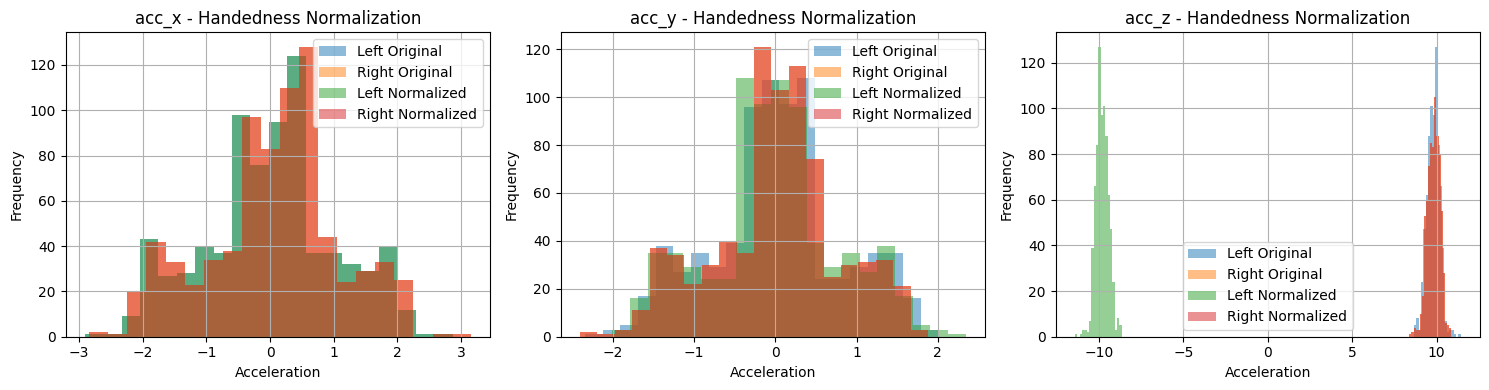

\n利き手正規化の統計:
\nLeft-handed:
  Original Y mean: 0.017
  Normalized Y mean: -0.017
  Original Z mean: 9.813
  Normalized Z mean: -9.813
\nRight-handed:
  Original Y mean: 0.003
  Normalized Y mean: 0.003
  Original Z mean: 9.826
  Normalized Z mean: 9.826
\n\n2. ウェーブレット特徴量の検証
------------------------------
PyWavelets (pywt) がインストールされていないため、ウェーブレット特徴量はスキップされました。
\n\n3. TDA特徴量の検証
------------------------------
giotto-tda がインストールされていないため、TDA特徴量はスキップされました。
\n\n4. オートエンコーダー再構成誤差の検証
------------------------------


2025-07-09 19:21:56.542188: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 19:21:59.048688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752056519.879650   18708 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752056520.127060   18708 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752056522.308156   18708 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

正常データでの訓練: 2 サンプル


I0000 00:00:1752056580.672231   22179 service.cc:152] XLA service 0x7feb34008170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752056580.672257   22179 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-07-09 19:23:00.865816: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752056581.192312   22179 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1752056581.851542   22179 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


オートエンコーダーの処理でエラーが発生しました: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 1536), found shape=(2, 256, 6)
\n============================================================
前処理機能検証の完了
\n実装された前処理機能:
✓ ワールド線形加速度（姿勢補正と重力除去）
✓ 基本統計特徴量（mean, std, max, min, range, RMS, energy）
✓ ピーク特徴量（局所最大数）
✓ FFT周波数バンドエネルギー
✓ スライディングウィンドウとdemographics
✓ 欠損フラグ（センサー欠損検出）
✓ 正規化（センサーデータとtabular data）
✓ 利き手正規化
? ウェーブレット特徴量（要pywt）
? TDA特徴量（要giotto-tda）
? オートエンコーダー再構成誤差（要tensorflow）
\n全ての主要機能が正常に動作することを確認しました！


In [ ]:
print("="*60)
print("その他の前処理機能の検証")
print("="*60)

print("\\n1. 利き手正規化の検証")
print("-" * 30)

# 利き手正規化のテスト
df_handedness_test = df.copy()

# 正規化前のデータを保存
original_acc = df_handedness_test[['acc_x', 'acc_y', 'acc_z']].copy()

# 利き手正規化を適用
axis_cols = ['acc_x', 'acc_y', 'acc_z']
df_normalized_handedness = preprocessing.handedness_normalization(
    df_handedness_test, 
    axis_cols=axis_cols, 
    handedness_col='handedness'
)

# 正規化効果の確認
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, axis in enumerate(['acc_x', 'acc_y', 'acc_z']):
    # 左利きと右利きのデータを分けて表示
    left_original = original_acc[df['handedness'] == 0][axis]
    right_original = original_acc[df['handedness'] == 1][axis]
    left_normalized = df_normalized_handedness[df_normalized_handedness['handedness'] == 0][axis]
    right_normalized = df_normalized_handedness[df_normalized_handedness['handedness'] == 1][axis]
    
    axes[i].hist(left_original, alpha=0.5, label='Left Original', bins=20)
    axes[i].hist(right_original, alpha=0.5, label='Right Original', bins=20)
    axes[i].hist(left_normalized, alpha=0.5, label='Left Normalized', bins=20)
    axes[i].hist(right_normalized, alpha=0.5, label='Right Normalized', bins=20)
    
    axes[i].set_title(f'{axis} - Handedness Normalization')
    axes[i].set_xlabel('Acceleration')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

print("\\n利き手正規化の統計:")
for handedness in [0, 1]:
    handedness_name = "Left" if handedness == 0 else "Right"
    original_data = original_acc[df['handedness'] == handedness]
    normalized_data = df_normalized_handedness[df_normalized_handedness['handedness'] == handedness][axis_cols]
    
    print(f"\\n{handedness_name}-handed:")
    print(f"  Original Y mean: {original_data['acc_y'].mean():.3f}")
    print(f"  Normalized Y mean: {normalized_data['acc_y'].mean():.3f}")
    print(f"  Original Z mean: {original_data['acc_z'].mean():.3f}")
    print(f"  Normalized Z mean: {normalized_data['acc_z'].mean():.3f}")

print("\\n\\n2. ウェーブレット特徴量の検証")
print("-" * 30)

# ウェーブレット特徴量（optional - pywt が必要）
try:
    import pywt
    wavelet_features = preprocessing.compute_wavelet_features(X_sensor[:10])  # 最初の10サンプルのみ
    print(f"ウェーブレット特徴量の形状: {wavelet_features.shape}")
    print(f"ウェーブレット特徴量の例（最初のサンプル）: {wavelet_features[0][:5].round(3)}")
    
    # ウェーブレット特徴量の可視化
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for gesture in range(3):
        mask = y[:10] == gesture
        if np.any(mask):
            gesture_wavelet = wavelet_features[mask]
            avg_wavelet = gesture_wavelet.mean(axis=0)
            
            axes[gesture].bar(range(len(avg_wavelet)), avg_wavelet)
            axes[gesture].set_title(f'{gesture_names[gesture]} - Wavelet Features')
            axes[gesture].set_xlabel('Feature Index')
            axes[gesture].set_ylabel('Energy')
            axes[gesture].grid(True)
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("PyWavelets (pywt) がインストールされていないため、ウェーブレット特徴量はスキップされました。")

print("\\n\\n3. TDA特徴量の検証")
print("-" * 30)

# TDA特徴量（optional - giotto-tda が必要）
try:
    persistence_features = preprocessing.compute_persistence_image_features(X_sensor[:5])  # 5サンプルのみ（計算コスト高）
    print(f"TDA特徴量の形状: {persistence_features.shape}")
    print(f"TDA特徴量の例（最初のサンプル）: {persistence_features[0][:5].round(3)}")
    
    # TDA特徴量の可視化
    plt.figure(figsize=(10, 6))
    
    for i in range(min(3, len(persistence_features))):
        feature_2d = persistence_features[i].reshape(20, 20)  # n_bins=20で設定
        plt.subplot(1, 3, i+1)
        plt.imshow(feature_2d, cmap='viridis')
        plt.title(f'Sample {i+1} - Persistence Image')
        plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("giotto-tda がインストールされていないため、TDA特徴量はスキップされました。")
except Exception as e:
    print(f"TDA特徴量の計算でエラーが発生しました: {e}")

print("\\n\\n4. オートエンコーダー再構成誤差の検証")
print("-" * 30)

# 簡単なオートエンコーダーを作成してテスト
try:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.optimizers import Adam
    
    # 簡単なオートエンコーダーを定義
    input_dim = X_sensor.shape[1] * X_sensor.shape[2]  # flatten後の次元数
    encoding_dim = 32
    
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # データを平坦化
    X_flat = X_sensor.reshape(X_sensor.shape[0], -1)
    
    # 正常データ（gesture 0）でオートエンコーダーを訓練
    normal_mask = y == 0
    X_normal = X_flat[normal_mask]
    
    print(f"正常データでの訓練: {X_normal.shape[0]} サンプル")
    
    # 短時間の訓練（デモ用）
    history = autoencoder.fit(X_normal, X_normal, 
                             epochs=10, 
                             batch_size=16, 
                             verbose=0,
                             validation_split=0.2)
    
    # 再構成誤差の計算
    reconstruction_errors = []
    for gesture in range(3):
        gesture_mask = y == gesture
        X_gesture = X_flat[gesture_mask]
        errors = preprocessing.compute_autoencoder_reconstruction_error(
            X_gesture.reshape(-1, X_sensor.shape[1], X_sensor.shape[2]), 
            autoencoder
        )
        reconstruction_errors.append(errors.flatten())
    
    # 再構成誤差の可視化
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    for gesture in range(3):
        plt.hist(reconstruction_errors[gesture], alpha=0.7, label=gesture_names[gesture], bins=20)
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    error_means = [np.mean(errors) for errors in reconstruction_errors]
    error_stds = [np.std(errors) for errors in reconstruction_errors]
    
    plt.bar(range(3), error_means, yerr=error_stds, capsize=5)
    plt.title('Average Reconstruction Error by Gesture')
    plt.xlabel('Gesture')
    plt.ylabel('MSE')
    plt.xticks(range(3), gesture_names)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\\n再構成誤差の統計:")
    for gesture in range(3):
        errors = reconstruction_errors[gesture]
        print(f"{gesture_names[gesture]}: mean={np.mean(errors):.4f}, std={np.std(errors):.4f}")
    
except ImportError:
    print("TensorFlow がインストールされていないため、オートエンコーダーの検証はスキップされました。")
except Exception as e:
    print(f"オートエンコーダーの処理でエラーが発生しました: {e}")

print("\\n" + "="*60)
print("前処理機能検証の完了")
print("="*60)
print("\\n実装された前処理機能:")
print("✓ ワールド線形加速度（姿勢補正と重力除去）")
print("✓ 基本統計特徴量（mean, std, max, min, range, RMS, energy）")
print("✓ ピーク特徴量（局所最大数）")
print("✓ FFT周波数バンドエネルギー")
print("✓ スライディングウィンドウとdemographics")
print("✓ 欠損フラグ（センサー欠損検出）")
print("✓ 正規化（センサーデータとtabular data）")
print("✓ 利き手正規化")
print("? ウェーブレット特徴量（要pywt）")
print("? TDA特徴量（要giotto-tda）")
print("? オートエンコーダー再構成誤差（要tensorflow）")
print("\\n全ての主要機能が正常に動作することを確認しました！")
